# Unsupervised Learning Techniques

## Clustering

In [1]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

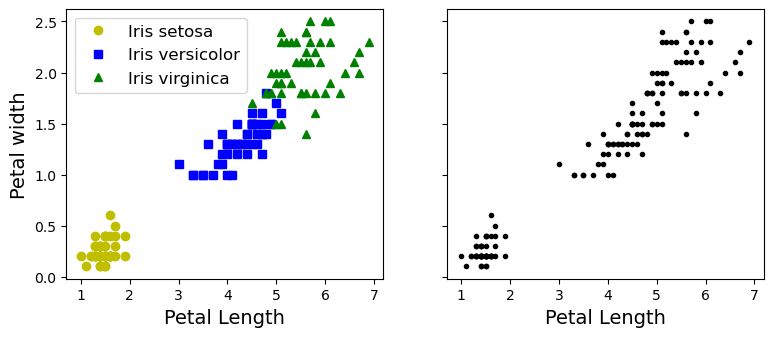

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:,2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal Length", fontsize=14)
plt.tick_params(labelleft=False)
plt.show()

Consider above figure: on the left is the iris dataset, where
each instance’s species (i.e., its class) is represented with a different
marker. It is a labeled dataset, for which classification algorithms such as
Logistic Regression, SVMs, or Random Forest classifiers are well suited.
On the right is the same dataset, but without the labels, so we cannot use a
classification algorithm anymore. This is where clustering algorithms step
in: many of them can easily detect the lower-left cluster. It is also quite
easy to see with our own eyes, but it is not so obvious that the upper-right
cluster is composed of two distinct sub-clusters. That said, the dataset has
two additional features (sepal length and width), not represented here, and
clustering algorithms can make good use of all features, so in fact they
identify the three clusters fairly well (e.g., using a Gaussian mixture
model, only 5 instances out of 150 are assigned to the wrong cluster).

### K-Means

Consider the unlabelled dataset represented in below figure

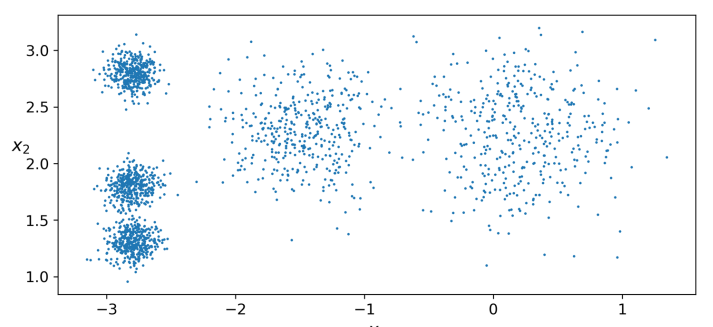

We can clearly see five blob of instances. The K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in few iterations. Sometimes referred as Lloyd-Forgy. 

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [2]:
from sklearn.datasets import make_blobs
import numpy as np

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [40]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

Note that we have to specify the number of clusters *k* that the algorithm
must find. In this example, it is pretty obvious from looking at the data
that k should be set to 5, but in general it is not that easy.

In [41]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
y_pred = kmeans.fit_predict(X)

In [42]:
y_pred

array([1, 1, 4, ..., 3, 2, 1], dtype=int32)

Each instance was assigned to one of the 5-clusters. In the context of
clustering, an instance’s *label* is the index of the cluster that this instance
gets assigned to by the algorithm: this is not to be confused with the class
labels in classification (remember that clustering is an unsupervised
learning task).

The `KMeans` instance preserves a copy of the labels of the
instances it was trained on, available via the `labels_` instance variable:

In [29]:
y_pred is kmeans.labels_

True

And following 5 *centeroids* (i.e., cluster centers) were estimated:

In [43]:
kmeans.cluster_centers_

array([[-1.46893704,  2.28372774],
       [-2.80214068,  1.55162671],
       [ 0.18304455,  2.55635115],
       [-2.79290307,  2.79641063],
       [ 0.23444426,  1.90682419]])

We can easily assign new instances to the cluster whose centroid is
closest:

In [44]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

If we plot the cluster’s decision boundaries, we get a Voronoi tessellation

In [50]:
import matplotlib.pyplot as plt

In [49]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

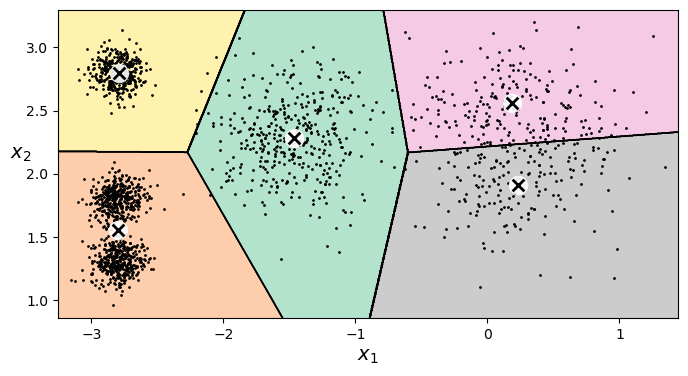

In [51]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

The vast majority of the instances were clearly assigned to the appropriate
cluster, but a few instances were probably mislabeled (especially near the
boundary between the top-left cluster and the central cluster). Indeed, the
K-Means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called `hard clustering`, it can be useful to give each instance a score per cluster, which is called `soft clustering`. The score can be the distance between the instance and the centeroid; conversely it can be a similarity score (or affinity) such as Gaussian Radial Bias function. 

In `KMeans` class, the `transform()` method measures the distance from each instance to every centeroid:

In [53]:
kmeans.transform(X_new)

array([[1.49608739, 2.83778629, 0.58568926, 2.9042344 , 0.25228128],
       [4.47793476, 5.81943941, 2.87136981, 5.84739223, 2.76712491],
       [1.69032533, 1.4618254 , 3.21381346, 0.29040966, 3.41418556],
       [1.54626242, 0.96879317, 3.18354332, 0.36159148, 3.28838672]])

In this example, the first instance of `X_new` ([0,2]) is located at distance 1.49 from the first centeroid, 2.83 from the second, 0.58 from the third, 2.90 from fourth and 0.29 from 5th. If we have a high-dimensional dataset and we transform it this way, we end up with a k-dimensional dataset: this transformation can be very efficient nonlinear dimensionality reduction technique.

we can see the algorithm in action in below figure: the centroids are
initialized randomly (top left), then the instances are labeled (top right),
then the centroids are updated (center left), the instances are relabeled
(center right), and so on. As we can see, in just three iterations, the
algorithm has reached a clustering that seems close to optimal.

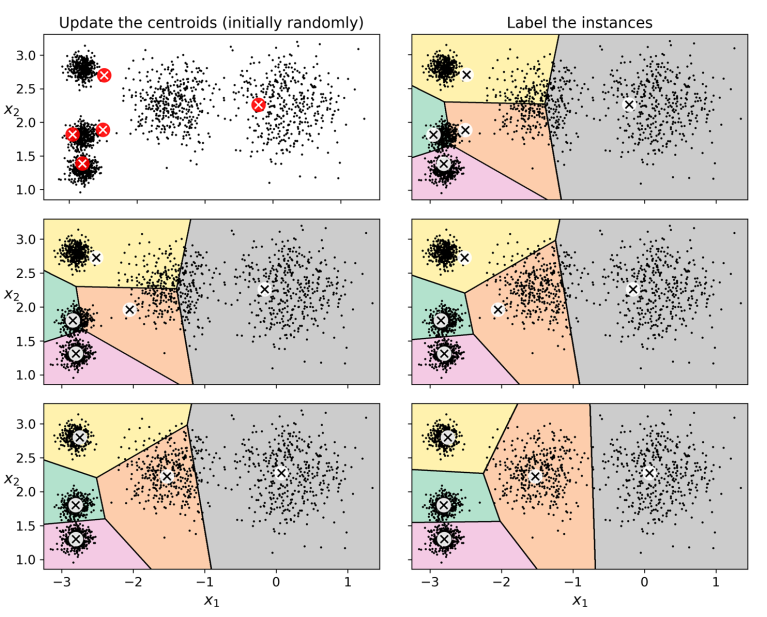

#### Centeroid Initialization Techniques

If we know approximately where the centeroids should be (e.g., if we ran another clustering algorithm earlier), then we can set the `init` hyperparameter to a Numpy array containing the list of centeroids, and set `n_init` to 1.

In [56]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

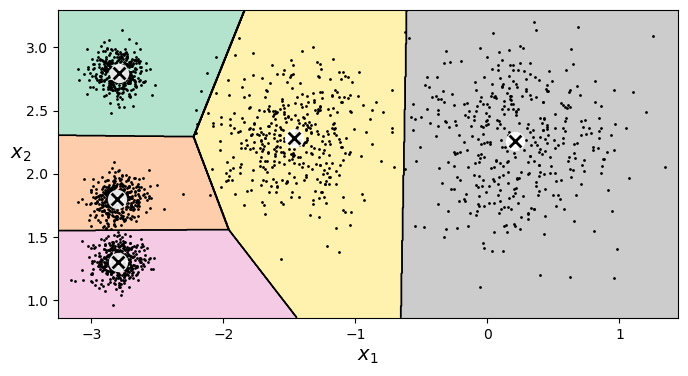

In [57]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

This is perfect plot as compared to earlier, so this centeroid initiazliation is much better

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. The number of random initializations is controlled by `n_init` hyperparameter: by default it is equal to 10, which means the whole algorithm described earlier runs 10 times when we call `fit()`, and Scikit-Learn keeps the best solution.

But how exactly does it know which solution is best? It uses a performance metric! That metric is called the model's `inertia`, which is the mean squared distance between each instance and its closest centeroid. Then `KMeans` class runs the algorithm `n_init` times and keeps the model with lowest inertia. A model's `inertia` is accessible via the `inertia_` instance variabel:

In [58]:
kmeans.inertia_

211.59853725816836

The `score()` method returns the negative inertia.

In [59]:
kmeans.score(X)

-211.59853725816836

Why negative? Because a predictor's `score()` method must always respect Scikit-Learn's "greater is better" rule: if a predictor is better than another, its `score()` should return a greator score.

An important improvement to the K-means algorithm, is K-Means++ . Authors introduced a smarter initialization step that tends to select centeroids that are distant from one another, and this improvement makes the K-Means much less likely to converge to suboptimal solution. They showed that the additional computation required for the smarter initialization step is well worth it because it makes it possible to drastically reduce the number of algorithm needs to be run to find the optimal solution. 

The `KMeans` class uses `KMeans++` initialization method by default. If we want to force it to use the original method (i.e., picking *k* instances randomly to define intial centeroids), then we can set the `init` hyperparameter to `"random"`. We will rarely need to do this.

#### Accelerated K-Means and mini-batch K-Means

Accelerated K-Means algorithm `KMeans` class uses by default (we can force it to use the original algorithm by setting the `algorithm` hyperparameter to `full`, although we probably will never need to).

Scikit Learn implements mini-batch K-Means in the `MiniBatchKMeans` class

In [61]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init="auto")
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, n_init='auto')

In [62]:
minibatch_kmeans.inertia_

211.62764025925281

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, as we did for incremental PCA in Chapter 8. Alternatively, we can pass one mini-batch at a time to the `partial_fit()` method, but this will require much more work, since we will need to perform multiple
initializations and select the best one ourself. See below code:

In [63]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

/home/dell/anaconda3/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], random_state=42)

Next, let's write it to `memmap`:

In [66]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mm[:] = X_train

In [68]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10, n_init="auto" ,random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=5, n_init='auto', random_state=42)

If our data is so large that we cannot use `memmap`, things get more complicated. Let's start by writing a function to load the next batch (in real life, we would load the data from disk):

In [70]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Now we can train the model by feeding it one batch at a time. We also need to implement multiple initializations and keep the model with the lowest inertia:

In [71]:
np.random.seed(42)

In [74]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size, n_init="auto")
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        # if the current iteration is within the last evaluate_on_last_n_iters iterations, the inertia of the clusters is added to minibatch_kmeans.sum_inertia_
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [75]:
best_kmeans.score(X)

-211.63546408155196

Although the Mini-batch K-Means algorithm is much faster than the
regular K-Means algorithm, its inertia is generally slightly worse,
especially as the number of clusters increases.

In [81]:
from timeit import timeit

times = np.empty((100,2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42, n_init=10)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10)
    print("\r{}\{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100\100

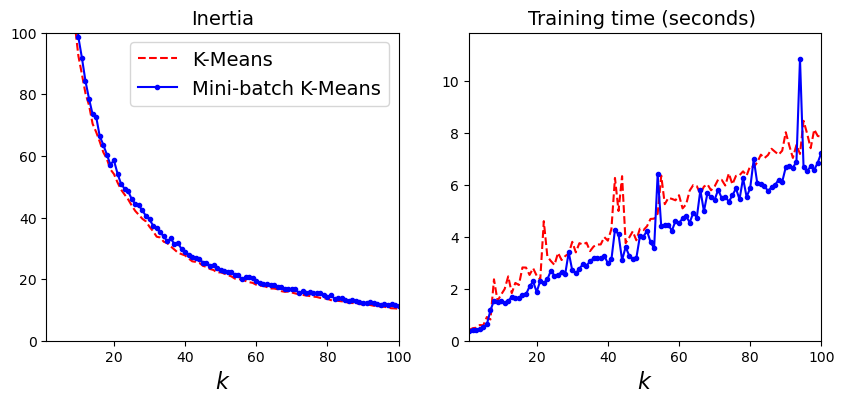

In [84]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])  

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds) ", fontsize=14)
plt.axis([1, 100, 0, times[:, 1].max() + 1])

plt.show()

We can see in above figure: the plot on the left compares the inertias of Mini-batch K-
Means and regular K-Means models trained on the previous dataset using various number of clusters *k*. The difference between two curves remains fairly constant, but this differene becomes more and more significant as *k* increases, since the inertia becomes smaller and smaller. In the plot on the right, we can see that Mini-Batch K-Means is much faster than regular K-Means and this difference increases with *k*.

#### Finding the optimal number of clusters.

So far we have set the number of clusters *k* to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it will not be easy to know how to set *k*, and the result might be quite bad if we set it to the wrong value. 

What if the number of clusters was set to lower to greater value than 5?

In [85]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

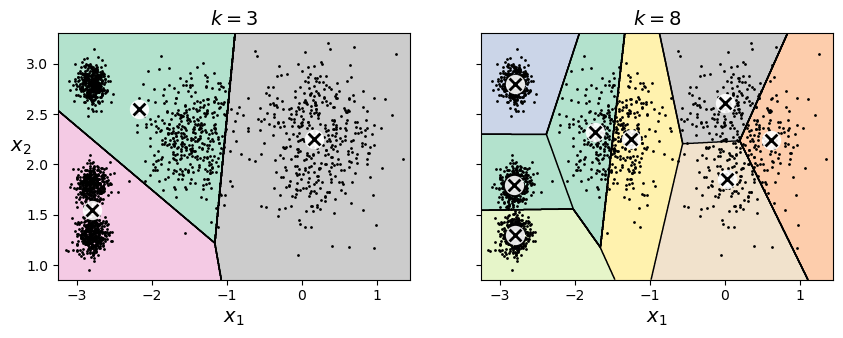

In [86]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init="auto")
kmeans_k8 = KMeans(n_clusters=8, random_state=42, n_init="auto")

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

As we can see setting *k* to 3 or 8 results in fairly bad models. When *k* is too small, seperate clusters get mergerd (left) and when *k* is large, some clusters get chopped into multiple species (right).

In [87]:
kmeans_k3.inertia_

653.2573264005187

In [88]:
kmeans_k8.inertia_

119.62408066631171

So we might be thinking that we could just pick the model with the lowest inertia, right? Unfortunately, it is not simple. The inertia for *k*=3 is 653.25 which is much higher than for *k*=5 (which was 211.58). But with *k*=8 the inertia is just 119.62. 

The inertia is not a good performance metric when trying to choose *k* because it keeps getting lower as *k* increases. Indeed, the more clusters there are, the closer each instance will be to its closest centeroid and therefore lower inertia will be.

Let's plot inertia as a function of *k*

In [92]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X) 
                for k in range (1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

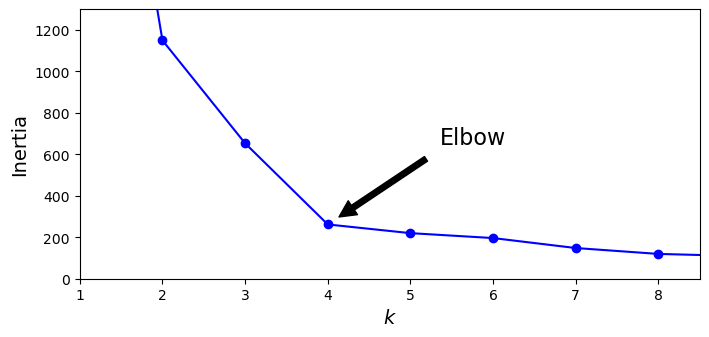

In [101]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate("Elbow", xy=(4, inertias[3]), xytext=(0.55, 0.55),
             textcoords="figure fraction", fontsize=16, 
             arrowprops=dict(facecolor="black", shrink=0.1))
plt.axis([1, 8.5, 0, 1300])
plt.show()

As we can see, the inertia drops very quickly as we increase *k* upto 4, but then it decreases much more slowly as we keep increasing *k*. This curve is has roughly the shape of an arm, and there is an "elbow" at *k* = 4. So, if we did not know better, 4 would be a good choice: any lower value would be dramatic, while any higher value would not help much, and we might just be splitting perfectly good clusters in half for no good reason. 

This technique for choosing the best value for the number of clusters is rather coarse. A more precise approach (but also more computationally expensive) is to use the *silhouette score*, which is the mean *silhouettee coefficient* over all the instances. 

To computer silhouette score, we can use Scikit-Learn's `silhouette_score()` function, giving all the instances in the dataset and the labels they were assigned:

In [102]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

Let's compare the silhouette score for different number of clusters:

In [105]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

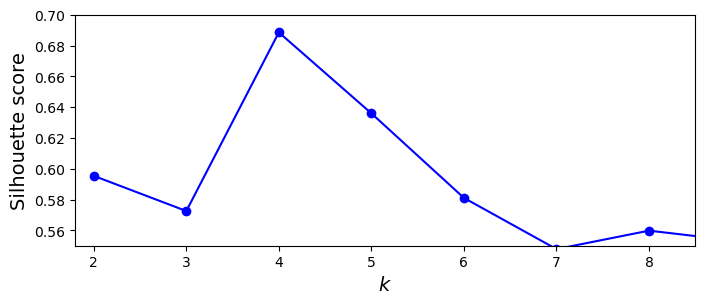

In [106]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As we can see this visualization is much richer than previous one: although it confirms that *k* = 4 is a very good choice, it also underlines the fact that *k* = 5 is also quite good as well, and much better than *k* = 6 or 7. This was not visible than comparing inertias.

An even more informative visualization is obtained when we plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called *silhouette diagram*.

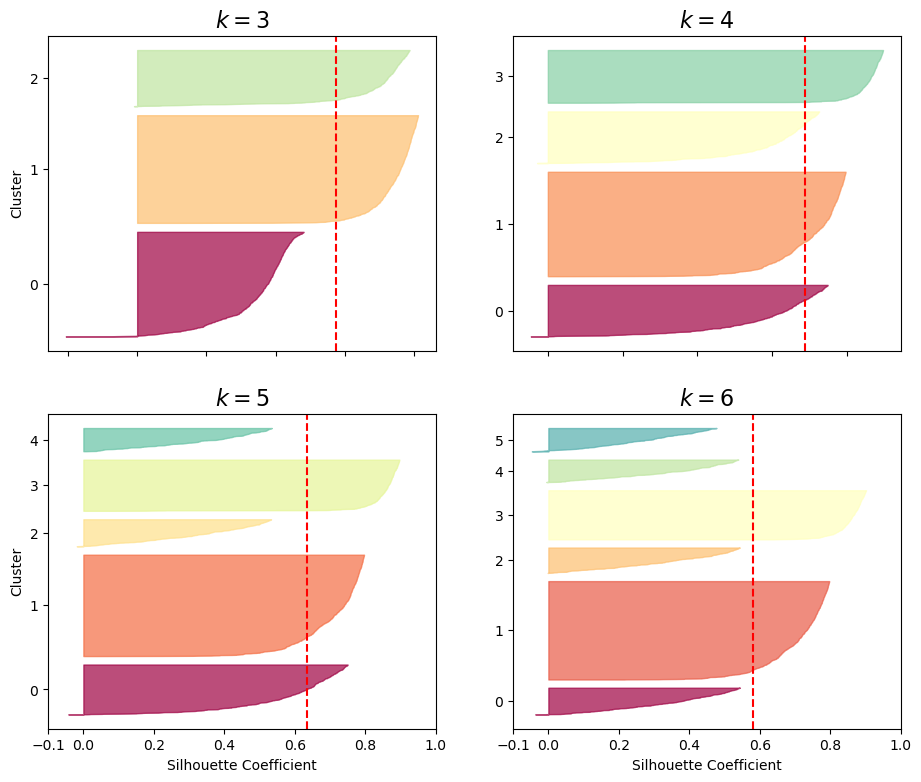

In [110]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

Each diagram contains one knife shape per cluster. The shape's height indicates the number of instances the cluster contains, and its width represents the sorted silhoutee coefficients of the instances in the cluster (wider is better). The dashed line indicates the mean silhouette coefficient.

The vertical dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when *k* = 3 and when *k* = 6, we get bad clusters. But when *k* = 4 or *k* = 5, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. When *k* = 4, the cluster with index 1 (the third from top) is rather big. When *k* = 5, all the clusters have similar sizes. So, even though the overall shilouette score from *k* = 4 is slightly greater than *k* = 5, it seems good idea to use *k* = 5 to get clusters of similar sizes.